# Homework 05 — IANNwTF
## Group 27
Deadline: Nov 28, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
# unimportant libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15

# Dataset

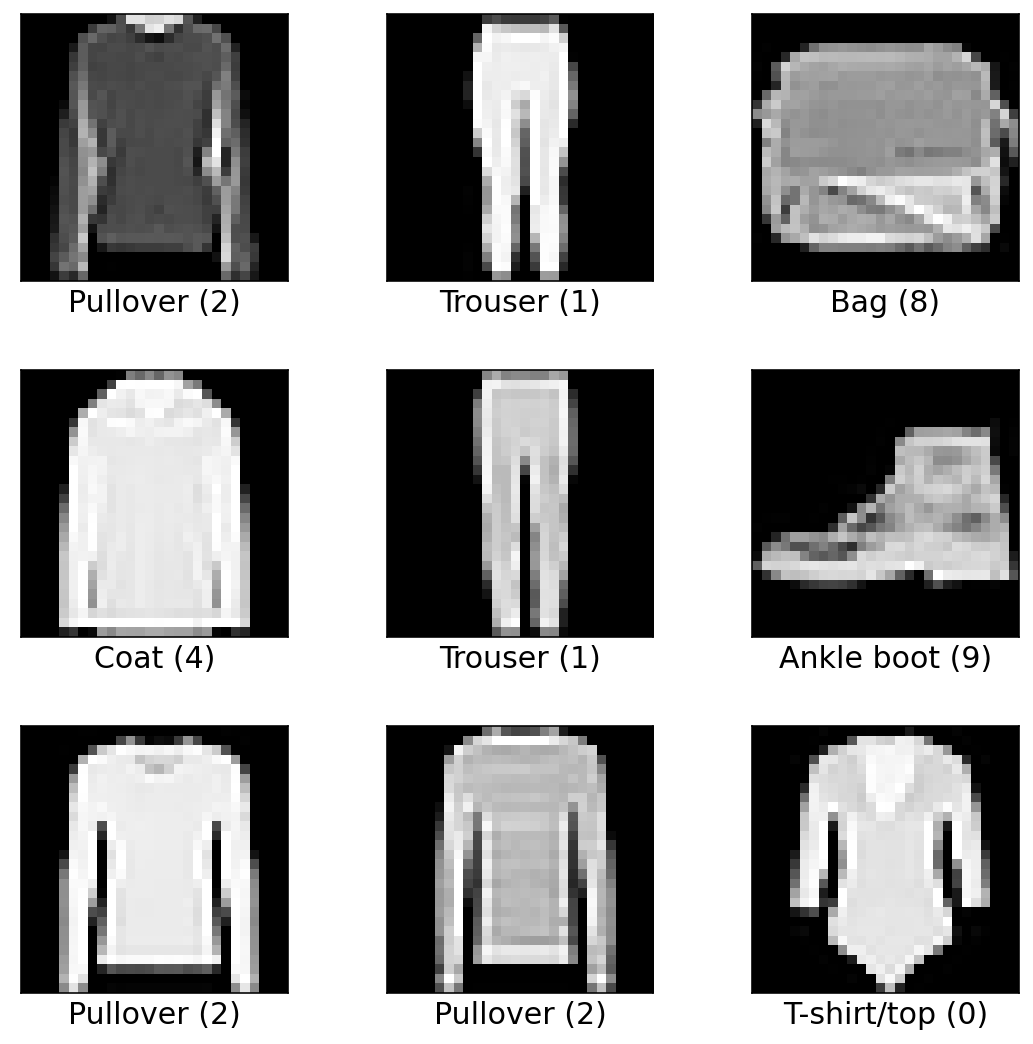

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [2]:
(train_ds, test_ds), info = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, with_info=True, as_supervised=True)
fig = tfds.show_examples(train_ds, info)
print(info)

In [4]:
for elem in train_ds.take(1):
    print("Image dimensions: ", elem[0].shape)
    print("Target: ", elem[1])

Image dimensions:  (28, 28, 1)
Target:  tf.Tensor(2, shape=(), dtype=int64)


In [5]:
def prepare_fashion_mnist_data(ds):
    # convert data from uint8 to float32
    ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # input normalization: bringing image values from range [0, 255] to [-1, 1]
    ds = ds.map(lambda img, target: ((img/128.)-1., target))
    # create one-hot targets
    ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache this progress in memory
    ds = ds.cache()
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000).batch(8).prefetch(20)
    # return preprocessed dataset
    return ds

In [6]:
train_ds = train_ds.apply(prepare_fashion_mnist_data)
test_ds = test_ds.apply(prepare_fashion_mnist_data)

In [7]:
for elem in train_ds.take(1):
    print("Image dimensions: ", elem[0].shape)
    input_shape = np.array(elem[0].shape) # save shape of model input for later when building the model
    print("Target: ", elem[1])

Image dimensions:  (8, 28, 28, 1)
Target:  tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(8, 10), dtype=float32)


# Model

In [63]:
##### this is a bit more than a DRAFT now!

# Custom Model
class MyModel(tf.keras.Model):
    
    """ 
    🌚

    Functions:
    init: constructor
    call: performs forward pass
    """
    def __init__(self):
        super(MyModel, self).__init__()
    
        # feature "learning"
        self.augmentation = tf.keras.layers.RandomRotation(0.2)
        self.augmentation_2 = tf.keras.layers.RandomFlip("horizontal_and_vertical")
        self.conv1 = tf.keras.layers.Conv2D(filters = 32,
                                            kernel_size = 3,
                                            padding="same",
                                            activation=None,
                                            kernel_regularizer = tf.keras.regularizers.L2(0.01),
                                            input_shape=(28,28,1))
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.activations.relu
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size = 2,
                                                  padding="same")
        self.dropout = tf.keras.layers.Dropout(0.3)

        self.conv2 = tf.keras.layers.Conv2D(filters = 64,
                                            kernel_size = 3,
                                            padding="same",
                                            activation=None,
                                            kernel_regularizer = tf.keras.regularizers.L2(0.01))
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.activation2 = tf.keras.activations.relu
        self.max_pool2 = tf.keras.layers.MaxPool2D(pool_size = 2,
                                                  padding="same")
        self.dropout2 = tf.keras.layers.Dropout(0.3)

        self.conv3 = tf.keras.layers.Conv2D(filters = 64,
                                            kernel_size = 3,
                                            padding="same",
                                            activation=None,
                                            kernel_regularizer = tf.keras.regularizers.L2(0.01))
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.activation3 = tf.keras.activations.relu
        self.max_pool3 = tf.keras.layers.MaxPool2D(pool_size = 2,
                                                  padding="same")
        self.dropout3 = tf.keras.layers.Dropout(0.5)
        
        # classifier
        self.flatted_input = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(128, activation='relu')
        self.output_layer = tf.keras.layers.Dense(10,
                                                  kernel_regularizer = tf.keras.regularizers.L2(0.01),
                                                  activation='softmax')
    
    def call(self, x, training = True):
        x = self.augmentation(x)
        x = self.augmentation_2(x)
        x = self.conv1(x)
        x = self.batch_norm(x, training)
        x = self.activation(x)
        x = self.max_pool(x)
        x = self.dropout(x, training)
        x = self.conv2(x)
        x = self.batch_norm2(x, training)
        x = self.activation2(x)
        x = self.max_pool2(x)
        x = self.dropout2(x, training)
        x = self.conv3(x)
        x = self.batch_norm3(x, training)
        x = self.activation3(x)
        x = self.max_pool3(x)
        x = self.dropout3(x, training)
        x = self.flatted_input(x)
        x = self.dense(x)
        x = self.output_layer(x)
        
        return x

# Training

In [64]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric):
    # training step
    with tf.GradientTape() as tape:
      predictions = model(inputs, training=True)
      loss = loss_fn(targets, predictions)
      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs[accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric, accuracy_metric):
    # test step
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs["val_" + accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["val_loss"] = loss_metric.result()
    return logs

In [65]:
tf.keras.backend.clear_session()

# Hyperparameters
epochs = 15
learning_rate = 0.001

# Initialize the model
model = MyModel()

# Initialize the loss function: categorical cross entropy
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)

# Metrics
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'val_loss': [], 'categorical_accuracy': [], 'val_categorical_accuracy': []}


def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

# training
for epoch in range(epochs):
    reset_metrics([accuracy_metric,loss_metric])
    for inputs, targets in train_ds:
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

# test
    reset_metrics([accuracy_metric,loss_metric])
    for (inputs_batch, targets_batch) in test_ds:
        logs = test_step(inputs_batch, targets_batch, loss_fn, loss_metric, accuracy_metric)
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...categorical_accuracy: 0.5802
...loss: 1.1300
...Evaluation results:
...val_categorical_accuracy: 0.7360
...val_loss: 0.7007
Results at the end of epoch 1
...categorical_accuracy: 0.6786
...loss: 0.8589
...Evaluation results:
...val_categorical_accuracy: 0.7536
...val_loss: 0.6596
Results at the end of epoch 2
...categorical_accuracy: 0.7030
...loss: 0.7961
...Evaluation results:
...val_categorical_accuracy: 0.7840
...val_loss: 0.5721
Results at the end of epoch 3
...categorical_accuracy: 0.7176
...loss: 0.7560
...Evaluation results:
...val_categorical_accuracy: 0.7740
...val_loss: 0.5858
Results at the end of epoch 4
...categorical_accuracy: 0.7307
...loss: 0.7268
...Evaluation results:
...val_categorical_accuracy: 0.7979
...val_loss: 0.5494
Results at the end of epoch 5
...categorical_accuracy: 0.7365
...loss: 0.7107
...Evaluation results:
...val_categorical_accuracy: 0.7968
...val_loss: 0.5425
Results at the end of epoch 6
...categorical_accuracy: 0.7

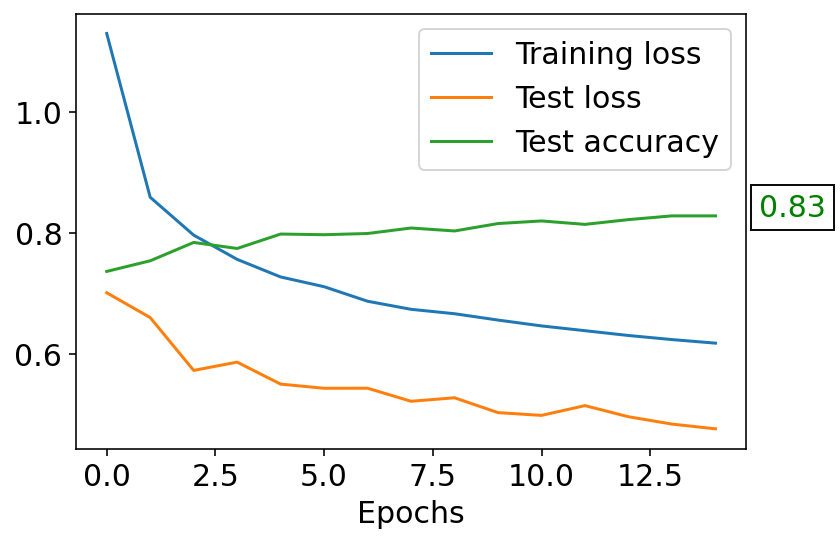

In [66]:
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Test loss')
plt.plot(hist['val_categorical_accuracy'], label='Test accuracy')
plt.text(epochs, hist['val_categorical_accuracy'][-1], round(hist['val_categorical_accuracy'][-1].numpy(),2),
         color = 'green',
         bbox = dict(facecolor = 'white', alpha = 0.95))
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [67]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  multiple                 0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  320       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                          